<a href="https://colab.research.google.com/github/anmolsabharwal/RedDevils/blob/master/RD_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing Important libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from google.colab import drive
import datetime
import plotly.figure_factory as ff
 
 
drive.mount('/content/drive')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#connection to .db file
gws = sqlite3.connect('/content/drive/My Drive/fpl.db')
gws = pd.read_sql_query("SELECT * FROM gw",gws)
gws.tail()


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
88499,Youri Tielemans,0,0,20,0,24.5,448,342,4,0,5.7,20.2,2020-07-12T18:00:00Z,90,3,0,0,0,0,44,0,290364,1,4,12,2,-1468,3543,5011,61,FALSE,0,149
88500,Yves Bissouma,0,0,8,0,1.9,53,343,5,0,0.7,5.4,2020-07-11T19:00:00Z,90,11,0,0,0,0,44,0,1910,5,0,0,1,50,117,67,50,TRUE,1,149
88501,Zech Medley,0,0,0,0,0,636,348,0,0,0,0,2020-07-12T15:30:00Z,0,17,0,0,0,0,44,0,1831,1,2,0,0,167,316,149,40,FALSE,0,149
88502,Çaglar Söyüncü,0,0,5,0,0.8,164,342,4,0,1,7.4,2020-07-12T18:00:00Z,66,3,0,0,0,1,44,0,1253775,1,4,2,-3,32374,51603,19229,50,FALSE,0,149
88503,Ørjan Nyland,0,0,0,0,0,27,341,0,0,0,0,2020-07-12T13:15:00Z,0,7,0,0,0,0,44,0,31410,0,2,0,0,-1673,413,2086,43,TRUE,0,149


In [3]:
gws.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'gw'],
      dtype='object')

In [4]:
#converting the datatypes of columns
gws=gws.astype({'name':'category','assists':int, 'bonus':int, 'bps':int, 'clean_sheets':int,
       'creativity':float,'element':int,'goals_conceded':int,
       'goals_scored':int, 'ict_index':float, 'influence':float,'minutes':int, 'opponent_team':int, 'own_goals':int,'penalties_missed':int, 'penalties_saved':int,
       'red_cards':int, 'round':int, 'saves':int, 'selected':int,
        # 'team_a_score':int, 'team_h_score':int,
        'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,
       'value':int, 'yellow_cards':int,'gw':int})

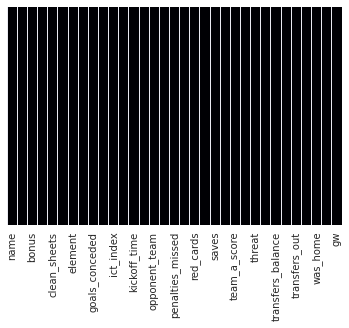

In [5]:
# cheking for null values
sns.set_style('dark')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno')

In [6]:
#assigning id to each specific player
gws = gws.assign(id=(gws['name']).astype('category').cat.codes)


In [7]:
# gws= gws[gws['minutes'] > 0] 


In [8]:
# a function to decide the fixture difficulty ratio based on the position of the opponent team
def fd(x):
  x=int(x)
  if x<=6:
    return '3'
  elif x>6 and x<=14:
    return '1'
  else:
    return '2'

In [9]:
gws.rename(columns={'opponent_team':'fdr'},inplace=True)


In [10]:
gws['fdr']=gws['fdr'].apply(fd).astype(float)


In [11]:
gws['kickoff_time']=pd.to_datetime(gws['kickoff_time'])

In [12]:
gws['kickoff_time'] = gws.kickoff_time.dt.hour


In [13]:
#divind the kickoff time into 3 categories 
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [14]:
gws['kickoff_time']=gws['kickoff_time'].apply(time).astype(float)
gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
0,Aaron Cresswell,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,55,FALSE,0,1,1
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,1,0,13918,1,1,0.0,1,0,0,0,60,TRUE,0,1,2
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,1,0,163170,4,3,23.0,2,0,0,0,80,TRUE,0,1,5
3,Abdoulaye Doucour�,0,0,0,0,0.0,482,7,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,1,0,1051,1,1,0.0,0,0,0,0,50,FALSE,0,1,11
4,Abdul Rahman Baba,0,0,0,0,0.0,80,10,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,1,0,1243,1,2,0.0,0,0,0,0,55,TRUE,0,1,12
5,Abel Hern�ndez,1,0,10,0,12.2,163,4,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,1,0,26039,1,2,30.0,5,0,0,0,60,TRUE,0,1,13
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,1,0,38151,1,2,45.0,8,0,0,0,45,TRUE,0,1,29
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,1,0,17663,1,1,9.0,2,0,0,0,45,TRUE,0,1,17
8,Adam Federici,0,0,0,0,0.0,30,9,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,1,0,4315,3,1,0.0,0,0,0,0,45,TRUE,0,1,18
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,1,0,2723,1,1,0.0,1,0,0,0,45,TRUE,1,1,19


In [15]:
# setting up the 'was_home' column to create binary attributes
def was_home(a):
  if a=="FALSE":
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [16]:
gws['home']=gws['was_home'].apply(was_home)

In [17]:
gws['Away Points'] = np.where(gws['home'] == 'Home', gws['total_points'] * 0,gws['total_points'])
gws['Home Points'] = np.where(gws['home'] == 'Away', gws['total_points'] * 0,gws['total_points'])

gws['Away Influence'] = np.where(gws['home'] == 'Home', gws['influence'] * 0,gws['influence'])
gws['Home Influence'] = np.where(gws['home'] == 'Away', gws['influence'] * 0,gws['influence'])

gws['Away Goals'] = np.where(gws['home'] == 'Home', gws['goals_scored'] * 0,gws['goals_scored'])
gws['Home Goals'] = np.where(gws['home'] == 'Away', gws['goals_scored'] * 0,gws['goals_scored'])

gws['Away Saves'] = np.where(gws['home'] == 'Home', gws['saves'] * 0,gws['saves'])
gws['Home Saves'] = np.where(gws['home'] == 'Away', gws['saves'] * 0,gws['saves'])

gws['Away Creativity'] = np.where(gws['home'] == 'Home', gws['creativity'] * 0,gws['creativity'])
gws['Home Creativity'] = np.where(gws['home'] == 'Away', gws['creativity'] * 0,gws['creativity'])

gws['Away ICT'] = np.where(gws['home'] == 'Home', gws['ict_index'] * 0,gws['ict_index'])
gws['Home ICT'] = np.where(gws['home'] == 'Away', gws['ict_index'] * 0,gws['ict_index'])

gws['Away Bonus'] = np.where(gws['home'] == 'Home', gws['bonus'] * 0,gws['bonus'])
gws['Home Bonus'] = np.where(gws['home'] == 'Away', gws['bonus'] * 0,gws['bonus'])

gws['Away Clean Sheets'] = np.where(gws['home'] == 'Home', gws['clean_sheets'] * 0,gws['clean_sheets'])
gws['Home Clean Sheets'] = np.where(gws['home'] == 'Away', gws['clean_sheets'] * 0,gws['clean_sheets'])

gws['Away Penalties Saved'] = np.where(gws['home'] == 'Home', gws['penalties_saved'] * 0,gws['penalties_saved'])
gws['Home Penalties Saved'] = np.where(gws['home'] == 'Away', gws['penalties_saved'] * 0,gws['penalties_saved'])

gws['Away Goals Conceded'] = np.where(gws['home'] == 'Home', gws['goals_conceded'] * 0,gws['goals_conceded'])
gws['Home Goals Conceded'] = np.where(gws['home'] == 'Away', gws['goals_conceded'] * 0,gws['goals_conceded'])

gws['Away Assists'] = np.where(gws['home'] == 'Home', gws['assists'] * 0,gws['assists'])
gws['Home Assists'] = np.where(gws['home'] == 'Away', gws['assists'] * 0,gws['assists'])

gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
0,Aaron Cresswell,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,55,FALSE,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,1,0,13918,1,1,0.0,1,0,0,0,60,TRUE,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,1,0,163170,4,3,23.0,2,0,0,0,80,TRUE,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0
3,Abdoulaye Doucour�,0,0,0,0,0.0,482,7,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,1,0,1051,1,1,0.0,0,0,0,0,50,FALSE,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
4,Abdul Rahman Baba,0,0,0,0,0.0,80,10,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,1,0,1243,1,2,0.0,0,0,0,0,55,TRUE,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
5,Abel Hern�ndez,1,0,10,0,12.2,163,4,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,1,0,26039,1,2,30.0,5,0,0,0,60,TRUE,0,1,13,Home,0,5,0.0,14.4,0,0,0,0,0.0,12.2,0.0,5.7,0,0,0,0,0,0,0,1,0,1
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,1,0,38151,1,2,45.0,8,0,0,0,45,TRUE,0,1,29,Home,0,8,0.0,45.2,0,1,0,0,0.0,16.8,0.0,10.7,0,2,0,0,0,0,0,1,0,0
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,1,0,17663,1,1,9.0,2,0,0,0,45,TRUE,0,1,17,Home,0,2,0.0,3.2,0,0,0,0,0.0,2.2,0.0,1.4,0,0,0,0,0,0,0,1,0,0
8,Adam Federici,0,0,0,0,0.0,30,9,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,1,0,4315,3,1,0.0,0,0,0,0,45,TRUE,0,1,18,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,1,0,2723,1,1,0.0,1,0,0,0,45,TRUE,1,1,19,Home,0,1,0.0,2.0,0,0,0,0,0.0,1.3,0.0,0.3,0,0,0,0,0,0,0,1,0,0


In [18]:
#dropping columns that are not required
gws.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [19]:
gws['value']=gws['value']*0.1



In [20]:
# a fucntion to put the points into the bins. This is where the business problem is convereted from a regression to a classification problem
def points(x):
  if x<=1:
    return 1
  elif x==2:
    return 2
  elif x>2 and x<7:
    return 3
  # elif x>=7 and x<10:
  #   return ('Good')
  # # # elif x>7 and x<=10:
  # # #   return 4
  else:
    return 4


In [21]:
gws['points']=gws['total_points'].apply(points)
gws1=gws.copy()
gws1.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0,1
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0,2
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
# point=pd.get_dummies(gws1['points'])
# gws1=pd.concat([gws1,point],axis=1)
# gws1.head()

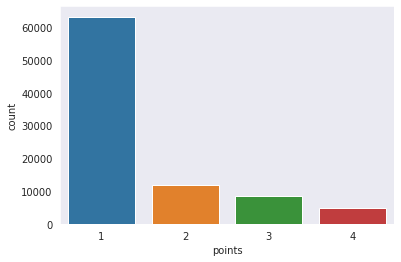

In [23]:
sns.countplot(gws1['points'])

In [24]:
#creating lags for different attributes

# gws1['Last_Week_Points'] = gws1.groupby(['id'])['total_points'].shift().astype(float)
# gws1['Last_2_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(2).astype(float)
#gws1['Last_3_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(3).astype(float)
#gws1['Last_4_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(4).astype(float)



gws1['Last_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift().astype(float)
# gws1['Last_2_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(2).astype(float)
#gws1['Last_3_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(3).astype(float)


gws1['Last_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift().astype(float)
# gws1['Last_2_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(2).astype(float)
# #gws1['Last_3_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(3).astype(float)


gws1['Last_Week_BPS'] = gws1.groupby(['id'])['bps'].shift().astype(float)
# gws1['Last_2_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(2).astype(float)
#gws1['Last_3_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(3).astype(float)


gws1['Last_Week_Assists'] = gws1.groupby(['id'])['assists'].shift().astype(float)
# gws1['Last_2_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(2).astype(float)
#gws1['Last_3_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(3).astype(float)


gws1['Last_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift().astype(float)
# gws1['Last_2_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(2).astype(float)
#gws1['Last_3_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(3).astype(float)


gws1['Last_Week_Influence'] = gws1.groupby(['id'])['influence'].shift().astype(float)
# gws1['Last_2_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(2).astype(float)
#gws1['Last_3_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(3).astype(float)


gws1['Last_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift().astype(float)
# gws1['Last_2_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(2).astype(float)
#gws1['Last_3_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(3).astype(float)


gws1['Last_Week_Threat'] = gws1.groupby(['id'])['threat'].shift().astype(float)
# gws1['Last_2_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(2).astype(float)
# #gws1['Last_3_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(3).astype(float)


gws1['Last_Week_Selected'] = gws1.groupby(['id'])['selected'].shift().astype(float)
# gws1['Last_2_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(2).astype(float)
#gws1['Last_3_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(3).astype(float)


gws1['Last_Week_Value'] = gws1.groupby(['id'])['value'].shift().astype(float)
# gws1['Last_2_Week_Value'] = gws1.groupby(['id'])['value'].shift(2).astype(float)
# gws1['Last_3_Week_Value'] = gws1.groupby(['id'])['value'].shift(3).astype(float)


gws1['Last_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift().astype(float)
# gws1['Last_2_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(2).astype(float)
# #gws1['Last_3_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(3).astype(float)



gws1['Last_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift().astype(float).astype(float)
# gws1['Last_2_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
# gws1['Last_3_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


gws1['Last_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift().astype(float)
# gws1['Last_2_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#gws1['Last_3_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(3).astype(float)


gws1['Last_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift().astype(float)
# gws1['Last_2_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#gws1['Last_3_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# gws1['Last_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift().astype(float)
# gws1['Last_2_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# gws1['Last_3_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(3).astype(float)


gws1['Last_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift().astype(float)
# gws1['Last_2_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(2).astype(float)
# gws1['Last_3_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(3).astype(float)


gws1['Last_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# gws1['Last_3_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(3).astype(float)


gws1['Last_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(2).astype(float)


gws1['Last_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift().astype(float)
# gws1['Last_2_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(2).astype(float)
# gws1['Last_3_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(3).astype(float)


gws1['Last_Week_Saves'] = gws1.groupby(['id'])['saves'].shift()
# gws1['Last_2_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(2)
#gws1['Last_3_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(3)


gws1['Last_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift()
# gws1['Last_2_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(2)
# gws1['Last_3_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(3)


# gws1['Last_Week_Home'] = gws1.groupby(['id'])['home'].shift()
# gws1['Last_2_Week_Home'] = gws1.groupby(['id'])['home'].shift(2)
# gws1['Last_3_Week_Home'] = gws1.groupby(['id'])['home'].shift(3)


gws1.head(100)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Last_Week_Goals,Last_Week_ICT,Last_Week_BPS,Last_Week_Assists,Last_Week_Bonus,Last_Week_Influence,Last_Week_Minutes_Played,Last_Week_Threat,Last_Week_Selected,Last_Week_Value,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Christian Fuchs,0,0,17,0,13.8,2,0,5.6,25.4,0.0,90,1.0,0,0,0,0,0,418306,17.0,0,5.5,1,1,252,Away,0,0,25.4,0.0,0,0,0,0,13.8,0.0,5.6,0.0,0,0,0,0,0,0,2,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Christian Kabasele,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,2810,0.0,0,5.0,0,1,253,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Chris Brunt,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,3.0,0,0,0,0,0,819,0.0,0,5.0,0,1,243,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,Chris Long,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,2.0,0,0,0,0,0,35760,0.0,0,4.5,0,1,244,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#creating binary attributes for was_home

home=pd.get_dummies(gws1['home'])
gws1=pd.concat([gws1,home],axis=1)
gws1.head()


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Last_Week_Goals,Last_Week_ICT,Last_Week_BPS,Last_Week_Assists,Last_Week_Bonus,Last_Week_Influence,Last_Week_Minutes_Played,Last_Week_Threat,Last_Week_Selected,Last_Week_Value,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards,Away,Home
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [142]:
#feature engineered a number of variables to better define the dependent variable

# hpm =gws1.groupby('id',as_index=False)['Home Points'].rolling(window=5).sum().shift(1)
# gws1["Home Points Form"] = hpm.reset_index(level=0, drop=True)

# apm =gws1.groupby('id',as_index=False)['Away Points'].rolling(window=5).sum().shift(1)
# gws1["Away Points Form"] = apm.reset_index(level=0, drop=True)

# ppm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
# gws1["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =gws1.groupby('id',as_index=False)['value'].expanding().sum()/gws1.groupby('id',as_index=False)['total_points'].expanding().sum()*90
gws1["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Assists per Min"] = apm.reset_index(level=0, drop=True)

# gpm =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
# gws1["Goals_90"] = gpm.reset_index(level=0, drop=True)

# ipm =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
# gws1["Influence_90"] = ipm.reset_index(level=0, drop=True)

# bpm =gws1.groupby('id',as_index=False)['bps'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
# gws1["BPS_90"] = ipm.reset_index(level=0, drop=True)

ih =gws1.groupby('id',as_index=False)['Home Influence'].rolling(window=5).sum().shift(1)
gws1["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Away Influence'].rolling(window=5).sum().shift(1)
gws1["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =gws1.groupby('id',as_index=False)['Home Goals'].rolling(window=5).sum().shift(1)
gws1["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['Away Goals'].rolling(window=5).sum().shift(1)
gws1["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =gws1.groupby('id',as_index=False)['goals_scored'].rolling(window=5).sum().shift(1)
gws1["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Save per min"] = s.reset_index(level=0, drop=True)

sh =gws1.groupby('id',as_index=False)['Home Saves'].rolling(window=5).sum().shift(1)
gws1["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =gws1.groupby('id',as_index=False)['Away Saves'].rolling(window=5).sum().shift(1)
gws1["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =gws1.groupby('id',as_index=False)['saves'].rolling(window=5).sum().shift(1)
gws1["Saves Form"] = sf.reset_index(level=0, drop=True)

ch =gws1.groupby('id',as_index=False)['Home Creativity'].rolling(window=5).sum().shift(1)
gws1["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =gws1.groupby('id',as_index=False)['Away Creativity'].rolling(window=5).sum().shift(1)
gws1["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =gws1.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=5).sum().shift(1)
gws1[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =gws1.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=5).sum().shift(1)
gws1["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['clean_sheets'].rolling(window=5).sum().shift(1)
gws1["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =gws1.groupby('id',as_index=False)['Home Bonus'].rolling(window=5).sum().shift(1)
gws1['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =gws1.groupby('id',as_index=False)['bonus'].rolling(window=5).sum().shift(1)
gws1['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =gws1.groupby('id',as_index=False)['Away Bonus'].rolling(window=5).sum().shift(1)
gws1["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =gws1.groupby('id',as_index=False)['Home ICT'].rolling(window=5).sum().shift(1)
gws1['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =gws1.groupby('id',as_index=False)['Away ICT'].rolling(window=5).sum().shift(1)
gws1["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =gws1.groupby('id',as_index=False)['ict_index'].rolling(window=5).sum().shift(1)
gws1["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Home Assists'].rolling(window=5).sum().shift(1)
gws1['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =gws1.groupby('id',as_index=False)['Away Assists'].rolling(window=5).sum().shift(1)
gws1["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =gws1.groupby('id',as_index=False)['assists'].rolling(window=5).sum().shift(1)
gws1["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['bps'].expanding().sum()
gws1["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =gws1.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=5).sum().shift(1)
gws1["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =gws1.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=5).sum().shift(1)
gws1["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].rolling(window=5).sum().shift(1)
gws1["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
gws1["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =gws1.groupby('id',as_index=False)['total_points'].rolling(window=5).sum().shift(1)
gws1["Points Form"] = tp.reset_index(level=0, drop=True)

yc =gws1.groupby('id',as_index=False)['yellow_cards'].rolling(window=5).sum().shift(1)
gws1["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =gws1.groupby('id',as_index=False)['red_cards'].rolling(window=5).sum().shift(1)
gws1["Red Cards Form"] = rc.reset_index(level=0, drop=True)

In [27]:
# gws1['dummy1']=gws1['goals_scored']
# gws1['dummy2']=gws1['clean_sheets']


In [143]:
# a function to capture the goal scoring streak of a player
def f(df):
    df['Goalstreak'] = (df['goals_scored'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['goals_scored'] == 0, 'cumsum'] = df['Goalstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Goal Streak'] = df['Goalstreak'] - df['cumsum']
    df.drop(['Goalstreak', 'cumsum'], axis=1, inplace=True)
    df['Goal Streak']=df['Goal Streak'].shift(1)
    return df


In [144]:
gws1=gws1.groupby('id').apply(f)


In [145]:
def f2(df):
    df['csstreak'] = (df['clean_sheets'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['clean_sheets'] == 0, 'cumsum'] = df['csstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Clean Sheet Streak'] = df['csstreak'] - df['cumsum']
    df.drop(['csstreak', 'cumsum'], axis=1, inplace=True)
    df['Clean Sheet Streak']=df['Clean Sheet Streak'].shift(1)
    return df


In [146]:
gws1=gws1.groupby('id').apply(f2)

In [147]:
def f3(df):
    df['psstreak'] = (df['penalties_saved'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['penalties_saved'] == 0, 'cumsum'] = df['psstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Penalty Save Streak'] = df['psstreak'] - df['cumsum']
    df.drop(['psstreak', 'cumsum'], axis=1, inplace=True)
    df['Penalty Save Streak']=df['Penalty Save Streak'].shift(1)
    return df

In [148]:
gws1=gws1.groupby('id').apply(f3)

In [34]:
# gws1.goals_scored.unique()

In [149]:
#dropping all the NAn, inf values created because of feature engineering
gws1=gws1.replace([np.inf, -np.inf], np.nan)

gws1=gws1.dropna()
gws1.head(200)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Home,Value_Point,Assists per Min,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Home Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,Home Assists Form,Away Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Mins per Goals Conceded,Points Form,Yellow Cards Form,Red Cards Form,Goal Streak,Clean Sheet Streak,Penalty Save Streak,Goals Form,Saves Form,Clean Sheets Form,Bonus Form,ICT Form,Assists Form,Goals Conceded Form
9037,Aaron Cresswell,0,0,4,0,5.0,4,0,1.1,2.2,2.0,90,1.0,0,0,0,0,0,18161,4.0,0,5.3,0,16,1,Home,0,0,0.0,2.2,0,0,0,0,0.0,5.0,0.0,1.1,0,0,...,1,261.818182,0.000000,11.2,43.8,0.0,0.0,0.002222,0.024444,0.017778,0.000000,0.0,0.0,13.9,84.6,1.0,0.0,0.0,0.0,2.5,14.9,0.0,0.0,6.000000,2.0,2.0,56.250000,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.4,0.0,4.0
9039,Aaron Ramsey,0,0,2,0,0.1,2,0,0.0,0.0,2.0,19,2.0,0,0,0,0,0,42044,1.0,1,7.6,0,16,5,Home,0,1,0.0,0.0,0,0,0,0,0.0,0.1,0.0,0.0,0,0,...,1,516.375000,0.000000,18.6,18.8,0.0,0.0,0.003247,0.025974,0.019481,0.000000,0.0,0.0,34.0,26.2,0.0,1.0,0.0,0.0,11.6,10.5,0.0,0.0,7.333333,3.0,1.0,51.333333,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22.1,0.0,4.0
9044,Adama Diomande,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,1.0,0,0,0,0,0,226141,0.0,0,4.5,0,16,29,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,0,270.000000,0.000000,11.0,1.8,0.0,0.0,0.002841,0.025568,0.019886,0.000000,0.0,0.0,28.9,24.1,0.0,1.0,0.0,0.0,5.1,5.5,0.0,0.0,13.037037,4.0,3.0,50.285714,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.6,0.0,7.0
9046,Adam Clayton,0,0,21,0,52.3,1,0,7.8,25.0,2.0,90,2.0,0,0,0,0,0,42506,1.0,2,4.3,0,16,17,Home,0,2,0.0,25.0,0,0,0,0,0.0,52.3,0.0,7.8,0,0,...,1,292.500000,0.000000,30.6,21.2,0.0,0.0,0.002681,0.021448,0.018767,0.000000,0.0,0.0,28.1,2.1,1.0,0.0,0.0,0.0,6.1,2.4,0.0,0.0,6.322034,3.0,3.0,53.285714,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.5,0.0,6.0
9048,Adam Forshaw,0,0,10,0,6.7,1,0,3.8,5.6,2.0,90,2.0,0,0,0,0,0,36323,26.0,2,4.5,0,16,19,Home,0,2,0.0,5.6,0,0,0,0,0.0,6.7,0.0,3.8,0,0,...,1,173.571429,0.000000,11.0,26.8,0.0,0.0,0.003774,0.026415,0.011321,0.000000,0.0,0.0,47.0,46.9,1.0,1.0,0.0,0.0,6.7,8.5,0.0,0.0,8.153846,3.0,2.0,88.333333,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,15.2,0.0,5.0
9049,Adam Lallana,0,0,3,0,5.8,1,0,1.8,2.6,2.0,89,3.0,0,0,0,0,0,990409,10.0,2,7.5,0,16,21,Home,0,2,0.0,2.6,0,0,0,0,0.0,5.8,0.0,1.8,0,0,...,1,270.000000,0.001901,30.4,48.8,0.0,0.0,0.001901,0.028517,0.017110,0.000000,0.0,0.0,57.6,73.8,1.0,0.0,0.0,0.0,11.0,30.5,1.0,0.0,7.514286,5.0,3.0,58.444444,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,41.5,1.0,8.0
9052,Adam Smith,0,0,18,0,26.9,2,0,3.9,9.6,2.0,90,3.0,0,0,0,0,0,340304,2.0,1,4.7,0,16,26,Home,0,1,0.0,9.6,0,0,0,0,0.0,26.9,0.0,3.9,0,0,...,1,252.900000,0.002494,38.8,39.4,0.0,0.0,0.000000,0.024938,0.027431,0.000000,0.0,0.0,27.6,7.3,0.0,0.0,2.0,0.0,7.3,5.7,1.0,0.0,5.346667,4.0,5.0,36.454545,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,13.0,1.0,9.0
9054,Adl�ne Gu�dioura,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,3447,0.0,0,4.3,0,16,34,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,1,260.000000,0.004082,39.2,0.0,0.0,0.0,0.000000,0.036735,0.032653,0.000000,0.0,0.0,25.0,6.1,0.0,0.0,0.0,0.0,7.3,1.3,1.0,0.0,6.282051,2.0,6.0,30.625000,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.6,1.0,8.0
9055,Adnan Januzaj,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,21999,0.0,0,5.3,0,16,35,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,1,240.000000,0.002421,25.2,36.2,

In [150]:
#calculating the correaltion of the different variables with the dependent variable
c=gws1.corr().abs()
cor_target = c['total_points']
# relevant_features = cor_target[cor_target>0.3]
# relevant_features
pd.set_option('display.max_rows', None)
cor_target.sort_values(ascending=False)

total_points                  1.000000
points                        0.915616
bps                           0.901242
influence                     0.818850
bonus                         0.755021
ict_index                     0.739784
Home Points                   0.702697
goals_scored                  0.664212
minutes                       0.598989
Home Influence                0.589318
Away Points                   0.584170
clean_sheets                  0.572492
Home Bonus                    0.566834
Home ICT                      0.522864
threat                        0.521421
Home Goals                    0.503454
Away Bonus                    0.481672
Away Influence                0.455113
assists                       0.452489
creativity                    0.441065
Home Clean Sheets             0.435011
Away Goals                    0.421549
Away ICT                      0.417278
Last_Week_Minutes_Played      0.391611
Points Form                   0.388236
ICT Form                 

In [37]:
#variance of each variable
gws1.var()

assists                       5.526640e-02
bonus                         2.858070e-01
bps                           1.098167e+02
clean_sheets                  1.134560e-01
creativity                    1.402516e+02
goals_conceded                1.073106e+00
goals_scored                  6.417526e-02
ict_index                     1.088983e+01
influence                     1.936119e+02
kickoff_time                  2.843430e-01
minutes                       1.739960e+03
fdr                           6.893890e-01
own_goals                     1.704342e-03
penalties_missed              1.195107e-03
penalties_saved               9.476836e-04
red_cards                     2.256635e-03
saves                         4.963483e-01
selected                      1.353064e+11
threat                        2.218745e+02
total_points                  7.221067e+00
value                         1.738130e+00
yellow_cards                  6.225095e-02
gw                            1.685926e+03
id         

In [151]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,Binarizer,scale
from imblearn.pipeline import Pipeline


In [152]:
gws1.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       ...
       'Goal Streak', 'Clean Sheet Streak', 'Penalty Save Streak',
       'Goals Form', 'Saves Form', 'Clean Sheets Form', 'Bonus Form',
       'ICT Form', 'Assists Form', 'Goals Conceded Form'],
      dtype='object', length=110)

In [154]:
#importing various other libraries and defining X and y set for testing and training
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from collections import Counter
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE






X=gws1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr','points'
,'Away Points','Home Points','Away Influence','Home Influence','Away Creativity','Home Creativity','Home Goals','Away Goals','Home Saves','Away Saves','Away ICT','Home ICT','Away Bonus','Home Bonus','Away Clean Sheets','Home Clean Sheets',
'Away Penalties Saved','Home Penalties Saved','Away Goals Conceded','Home Goals Conceded','Away Assists','Home Assists'],axis=1)
y=gws1['points']






In [153]:
# #dividing the dataset into testing and training data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=101,stratify=y)


In [42]:
# #since there is a class imbalance, we have undersampled the majority class
# from imblearn.under_sampling import NearMiss

# # define the undersampling method
# undersample = NearMiss(version=1, n_neighbors=3)
# # transform the dataset
# X_train, y_train = undersample.fit_resample(X_train, y_train)
# # summarize the new class distribution
# counter = Counter(y_train1)
# print(counter)

In [43]:
# sm = SMOTE(random_state=12, ratio = (1.0,1.0,1.0,0.1)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# counter = Counter(y_train_res)
# print(counter)

In [155]:
nof_list=np.arange(1,len(gws1.columns)
)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 63
Score with 63 features: 0.253232


In [156]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 54)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['kickoff_time', 'Last_Week_Goals', 'Last_Week_ICT', 'Last_Week_BPS',
       'Last_Week_Assists', 'Last_Week_Bonus', 'Last_Week_Influence',
       'Last_Week_Minutes_Played', 'Last_Week_Threat', 'Last_Week_Value',
       'Last_Week_Creativity', 'Last_Week_FDR', 'Last_Week_Clean_Sheets',
       'Last_Week_Goals_Conceded', 'Last_Week_Own_Goals',
       'Last_Week_Penalties_Missed', 'Last_Week_Penalties_Saved',
       'Last_Week_Red_Cards', 'Last_Week_Saves', 'Last_Week_Yellow_Cards',
       'Away', 'Home', 'Assists per Min', 'Away Influence Form',
       'Clean Sheets per Min', 'Points Per Min', 'Goals Conceded Per Min',
       'Save per min', 'Home Saves Form', 'Away Saves Form',
       'Home Creativity Form', ' Home Clean Sheets Form',
       'Away Clean Sheets Form', 'Home Bonus Form', 'Away Bonus Form',
       'Away ICT Form', 'Home Assists Form', 'Away Assists Form',
       'Mins Per BPS', 'Away Goals Concecded Form', 'Goals Conceded Home',
       'Points Form', 'Yellow Cards 

In [157]:
X1=gws1[[
       'Last_Week_Minutes_Played',
        'Last_Week_Selected',
       'Last_Week_FDR',
       'Last_Week_Penalties_Missed',
       'Red Cards Form', 'Saves Form', 'Yellow Cards Form',
       'Away', 'Home',
       'Value_Point', 'Assists per Min','Clean Sheets per Min', 'Points Per Min', 'Goals Conceded Per Min',
       'Save per min', 'Saves Form','Clean Sheets Form', 'Bonus Form',
       'Home ICT Form', 'Away ICT Form',
       'Assists Form','Mins Per BPS',
        'Goals Conceded Form',
       'Mins per Goals Conceded','Goal Streak','Clean Sheet Streak',
       'Penalty Save Streak','Points Form']]
y1=gws1['points']
smote=SMOTE(sampling_strategy='all')
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.30, random_state=134,stratify=y)
print(sum(y_train==1))
print(sum(y_train==2))
print(sum(y_train==3))
print(sum(y_train==4))

X_train,y_train=smote.fit_sample(X_train,y_train)
print(sum(y_train==1))
print(sum(y_train==2))
print(sum(y_train==3))
print(sum(y_train==4))


24767
6356
4681
2746


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



24767
24767
24767
24767


In [158]:
# since we had a lot of attributes we decided the reduce it using PCA and scaled it
scaler= StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
# from sklearn.decomposition import PCA
# pca = PCA(0.80)
# pca.fit_transform(X_train)
# X_train=pca.transform(X_train)
# X_test=pca.transform(X_test)



In [48]:
# #hyper parameter tuning
# model=LogisticRegression()
# solvers = ['newton-cg', 'lbfgs']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [49]:
# List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X,y)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [50]:
# model = XGBClassifier()
# # define grid
# weights = [1, 10,15,20, 25,30,35]
# param_grid = dict(scale_pos_weight=weights)
# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# # execute the grid search
# grid_result = grid.fit(X_train, y_train)
# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [51]:
# #Hypertuning XGBoost

# estimator = XGBClassifier(
#     objective= 'binary:logistic',
#     nthread=4,
#     seed=42
# )

# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     scoring = 'roc_auc',
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )

# grid_search.fit(X_train, y_train)
# grid_search.best_estimator_


In [171]:
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.utils import class_weight
# Observe how I imported Pipeline from IMBLEARN and not SKLEARN
from imblearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

# This pipeline will resample the data and  
# pass the output to MultinomialNB
# pipe = Pipeline([('sampl', SMOTEENN()), 
#                  ('clf', LogisticRegression(max_iter=5000,class_weight='balanced'))])

# OVR will transform the `y` as you know and 
# then pass single label data to different copies of pipe 
# multiple times (as many labels in data)
ovr = LogisticRegression(max_iter=5000,multi_class='ovr')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(ovr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Accuracy: %.3f' % np.mean(scores))
ovr.fit(X_train, y_train)




Mean ROC AUC: 0.487


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# #training the model


# #model=RandomForestClassifier()
# #model=RandomForestRegressor()
# #model=KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=8)
# #model=LogisticRegression(C=10,solver='newton-cg',penalty='l2',class_weight='balanced')
# # model=XGBClassifier(scale_pos_weight=40,base_score=0.5, booster='gbtree', colsample_bylevel=1,
# #               colsample_bynode=1, colsample_bytree=1, gamma=0,
# #               learning_rate=0.1, max_delta_step=0, max_depth=6,
# #               min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
# #               nthread=4, objective='binary:logistic', random_state=0,
# #               reg_alpha=0, reg_lambda=1, seed=42,
# #               silent=None, subsample=1, verbosity=1)
# #model=DecisionTreeClassifier()
# #model=Lasso()
# #model=Ridge()
# #model=LinearRegression()
# #model=sm.OLS(X_train,y_train)
# #model=SGDRegressor(eta0=0.0001)
# model=LogisticRegression(max_iter=5000,class_weight='balanced')
# #model1 = BalancedRandomForestClassifier()
# #model1 = RandomForestClassifier(class_weight='balanced')
# model1= OneVsRestClassifier(model)


# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# # # evaluate model
# # scores = cross_val_score(model1, X_train1, y_train1, scoring='accuracy', cv=cv, n_jobs=-1)
# # # summarize performance
# # print('Mean ROC AUC: %.3f' % np.mean(scores))

# model1.fit(X_train1, y_train)

In [172]:
#predicting the values 
# predict=model1.predict(X_test)
predict=ovr.predict(X_test)
predictp=ovr.predict_proba(X_test)


In [173]:
# predict = model.predict(X_test)
df1=pd.DataFrame({'Actual':y_test,'Predicted':predict})
df1[1]=predictp[:,0].round(decimals=2)
df1[2]=predictp[:,1].round(decimals=2)
df1[3]=predictp[:,2].round(decimals=2)
df1[4]=predictp[:,3].round(decimals=2)

df1.head(40)


,Actual,Predicted,1,2,3,4
41135,3,1,0.43,0.07,0.16,0.34
51166,1,1,1.00,0.00,0.00,0.00
41925,1,1,0.49,0.27,0.23,0.02
33307,3,1,0.55,0.16,0.18,0.12
49756,1,1,0.55,0.07,0.18,0.20
60657,1,1,0.65,0.11,0.01,0.22
70728,1,1,0.61,0.17,0.14,0.09
86170,1,1,0.77,0.18,0.05,0.01
20129,1,1,0.78,0.02,0.05,0.15
53296,1,1,0.68,0.12,0.14,0.06


In [174]:
from sklearn.metrics import classification_report, confusion_matrix,auc, roc_auc_score
print(classification_report(y_test,predict))
print(balanced_accuracy_score(y_test,predict))


              precision    recall  f1-score   support

           1       0.87      0.70      0.77     10615
           2       0.32      0.42      0.36      2724
           3       0.27      0.30      0.29      2006
           4       0.23      0.46      0.31      1177

    accuracy                           0.59     16522
   macro avg       0.43      0.47      0.43     16522
weighted avg       0.66      0.59      0.61     16522

0.4686127263647539


In [175]:
ovr.score(X_test,y_test)



0.5853407577775088

In [ ]:
sns.countplot(gws1['points'])

In [ ]:
x=pd.read_csv('/content/drive/My Drive/combined_2016-2020-1.csv',encoding = "ISO-8859-1")

x.tail()


In [ ]:
x=x.astype({'was_home':str})

In [ ]:
x = x.assign(id=(x['name']).astype('category').cat.codes)


In [ ]:
x.rename(columns={'opponent_team':'fdr'},inplace=True)


In [ ]:
# x['fdr']=x['fdr'].apply(fd).astype(float)


In [ ]:
x['kickoff_time']=pd.to_datetime(x['kickoff_time'])

In [ ]:
x['kickoff_time'] = x.kickoff_time.dt.hour

In [ ]:
x['kickoff_time']=x['kickoff_time'].apply(time).astype(float)
x.head(20)

In [ ]:
def was__home(a):
  if a=='False':
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [ ]:
x['home']=x['was_home'].apply(was__home)
x.head()

In [ ]:
x.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [ ]:
x['value']=x['value']*0.1


In [ ]:
x['points']=x['total_points'].apply(points)
x.head(100)

In [ ]:
home=pd.get_dummies(x['home'])
x=pd.concat([x,home],axis=1)
x.head(100)

In [ ]:
x['Last_Week_Points'] = x.groupby(['id'])['points'].shift().astype(float)
# x['Last_2_Week_Points'] = x.groupby(['id'])['points'].shift(2).astype(float)
#x['Last_3_Week_Points'] = x.groupby(['id'])['total_points'].shift(3).astype(float)
#x['Last_4_Week_Points'] = x.groupby(['id'])['total_points'].shift(4).astype(float)



x['Last_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift().astype(float)
# x['Last_2_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(2).astype(float)
#x['Last_3_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(3).astype(float)


x['Last_Week_ICT'] = x.groupby(['id'])['ict_index'].shift().astype(float)
x['Last_2_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(2).astype(float)
# #x['Last_3_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(3).astype(float)


x['Last_Week_BPS'] = x.groupby(['id'])['bps'].shift().astype(float)
x['Last_2_Week_BPS'] = x.groupby(['id'])['bps'].shift(2).astype(float)
#x['Last_3_Week_BPS'] = x.groupby(['id'])['bps'].shift(3).astype(float)


x['Last_Week_Assists'] = x.groupby(['id'])['assists'].shift().astype(float)
x['Last_2_Week_Assists'] = x.groupby(['id'])['assists'].shift(2).astype(float)
#x['Last_3_Week_Assists'] = x.groupby(['id'])['assists'].shift(3).astype(float)


x['Last_Week_Bonus'] = x.groupby(['id'])['bonus'].shift().astype(float)
x['Last_2_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(2).astype(float)
#x['Last_3_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(3).astype(float)


x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)
x['Last_2_Week_Penalties_Saved'] =x.groupby(['id'])['penalties_saved'].shift(2).astype(float)


x['Last_Week_Influence'] = x.groupby(['id'])['influence'].shift().astype(float)
x['Last_2_Week_Influence'] = x.groupby(['id'])['influence'].shift(2).astype(float)
#x['Last_3_Week_Influence'] = x.groupby(['id'])['influence'].shift(3).astype(float)


x['Last_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift().astype(float)
x['Last_2_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(2).astype(float)
#x['Last_3_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(3).astype(float)


x['Last_Week_Threat'] = x.groupby(['id'])['threat'].shift().astype(float)
x['Last_2_Week_Threat'] = x.groupby(['id'])['threat'].shift(2).astype(float)
# #x['Last_3_Week_Threat'] = x.groupby(['id'])['threat'].shift(3).astype(float)


x['Last_Week_Selected'] = x.groupby(['id'])['selected'].shift().astype(float)
x['Last_2_Week_Selected'] = x.groupby(['id'])['selected'].shift(2).astype(float)
#x['Last_3_Week_Selected'] = x.groupby(['id'])['selected'].shift(3).astype(float)


x['Last_Week_Value'] = x.groupby(['id'])['value'].shift().astype(float)
x['Last_2_Week_Value'] = x.groupby(['id'])['value'].shift(2).astype(float)
# x['Last_3_Week_Value'] = x.groupby(['id'])['value'].shift(3).astype(float)


x['Last_Week_Creativity'] = x.groupby(['id'])['creativity'].shift().astype(float)
x['Last_2_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(2).astype(float)
# #x['Last_3_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(3).astype(float)



x['Last_Week_FDR'] = x.groupby(['id'])['fdr'].shift().astype(float).astype(float)
x['Last_2_Week_FDR'] = x.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
x['Last_3_Week_FDR'] = x.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


x['Last_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift().astype(float)
x['Last_2_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#x['Last_3_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(3).astype(float)


x['Last_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift().astype(float)
x['Last_2_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#x['Last_3_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# x['Last_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift().astype(float)
# x['Last_2_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# x['Last_3_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(3).astype(float)


x['Last_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift().astype(float)
x['Last_2_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(2).astype(float)
# x['Last_3_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(3).astype(float)


x['Last_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift().astype(float)
x['Last_2_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# x['Last_3_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift(3).astype(float)


x['Last_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift().astype(float)
x['Last_2_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(2).astype(float)
# x['Last_3_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(3).astype(float)


x['Last_Week_Saves'] = x.groupby(['id'])['saves'].shift()
x['Last_2_Week_Saves'] = x.groupby(['id'])['saves'].shift(2)
#x['Last_3_Week_Saves'] = x.groupby(['id'])['saves'].shift(3)


x['Last_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift()
x['Last_2_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(2)
# x['Last_3_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(3)


# x['Last_Week_Home'] = x.groupby(['id'])['home'].shift()
# x['Last_2_Week_Home'] = x.groupby(['id'])['home'].shift(2)
# x['Last_3_Week_Home'] = x.groupby(['id'])['home'].shift(3)
hpm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Home Points"] = hpm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Away Points"] = apm.reset_index(level=0, drop=True)

ppm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =x.groupby('id',as_index=False)['value'].expanding().sum()/x.groupby('id',as_index=False)['total_points'].expanding().sum()*90
x["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Assists_90"] = ppm.reset_index(level=0, drop=True)

gpm =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =x.groupby('id',as_index=False)['bps'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["BPS_90"] = ipm.reset_index(level=0, drop=True)

ih =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Home Influence"] = ih.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Away Influence"] = ah.reset_index(level=0, drop=True)

hg =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Home Goals"] = hg.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Clean Sheets_90"] = ag.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Points_90"] = cs.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Goals_Conceded_90"] = gc.reset_index(level=0, drop=True)

s =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Saves_90"] = s.reset_index(level=0, drop=True)

sh =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Saves Home"] = sh.reset_index(level=0, drop=True)

sa =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Saves Away"] = sa.reset_index(level=0, drop=True)

ch =x.groupby('id',as_index=False)['creativity'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Creativity Home"] = ch.reset_index(level=0, drop=True)

ca =x.groupby('id',as_index=False)['creativity'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Creativity Away"] = ca.reset_index(level=0, drop=True)

csh =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Clean Sheets Home"] = csh.reset_index(level=0, drop=True)

csa =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Clean Sheets Away"] = csa.reset_index(level=0, drop=True)

bph =x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x['Bonus Home'] = bph.reset_index(level=0, drop=True)

bpa =x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Bonus Away"] = bpa.reset_index(level=0, drop=True)

icth =x.groupby('id',as_index=False)['ict_index'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x['ICT Home'] = icth.reset_index(level=0, drop=True)

icta =x.groupby('id',as_index=False)['ict_index'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["ICT Away"] = icta.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x['Assists Home'] = ah.reset_index(level=0, drop=True)

aa =x.groupby('id',as_index=False)['ict_index'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Assists Away"] = aa.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum()
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Goals Concecded Away"] = gca.reset_index(level=0, drop=True)

gch =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)


x.head(100)

In [ ]:
x=x.groupby('id').apply(f)
x=x.groupby('id').apply(f2)
x=x.groupby('id').apply(f3)

In [ ]:
x1=x[x['gw']==150]
x1.head(40)

In [ ]:
x_test=x1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr'],axis=1)
x_test=x_test.replace([np.inf, -np.inf], np.nan)
x_test=x_test.dropna()
x_testf=x1.drop(['points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home'],axis=1)
x_testf=x_testf.replace([np.inf, -np.inf], np.nan)
x_testf=x_testf.dropna()
x_test.head(100)


In [ ]:
x_test1=scaler.fit_transform(x_test)
x_test2=pca.transform(x_test1)
predict1=model.predict(x_test2)


In [ ]:
predict1=pd.DataFrame(predict1)
predict1.head(100)
df1 = pd.concat([x_testf.reset_index(drop='Tru‌​e'),predict1.reset_index(drop='Tru‌​e')],axis=1)
df1.head()


In [ ]:
df1.to_csv('/content/drive/My Drive/29.csv')